Import all necessary libraries. These can be installed with `poetry install --no-root`

In [30]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import time

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### **Data Loading**

The data loading starts by defining the transforms. The transforms.Compose() defines a sequence of transforms to perform on the dataset.
- transforms.ToTensor(): Converts the data to tensors
- transforms.Normalize(): Normalizes the data - since this data is pixel values, there are three channels that need normalized (RGB). They're being normalized to between 0 and 1, so the mean and std are both 0.5 for each channel

The data is then downloaded from the torchvision datasets and wrapped as DataLoaders so that they can be iterated over for training/evaluation

In [68]:
# Define the batch size and number of workers
BATCH_SIZE = 20
NUM_WORKERS = 0

# Define a transform to normalize the data
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
target_transform = transforms.Compose([lambda x: F.one_hot(x, num_classes=10).to(float)])

# Download and load the training data
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### **Convolutional Neural Network (CNN)**

Since the images are bigger than the MNIST dataset (32x32 vs 28x28) and they have more features to represent (animals with background noise vs black and white numbers), the CIFAR dataset requires a convolutional neural network. This process is shown in the GIF below.

![convolution_gif](images/convolution.gif)  
*From ![https://github.com/nvan21/image-classification]*

This network has two convolutional layers, then a max pooling layer, finished off by three fully connected linear layers. Each layer is explained below.
- **Convolution Layer 1:** This layer takes in 3 inputs (since there is a red, green, and blue channel) and has an output of 16 channels (arbitrary number of kernel features that the network will learn). Each kernel is a matrix of weights that are trained to detect image features like edges, textures, etc. For this network, the output data shape is 32 x 32 x 16 where the format is `[width_values], [height_values], [output_features]`
- **Convolution Layer 2:** This layer takes in 16 inputs (the outputs from the previous layer) and has 32 outputs. This means the network will learn 16 different features through the 32 different kernel matrices. The input data size to this layer is 16x16 since there's a 2x2 max pooling layer between this layer and the first convolutional layer (read below). The output data shape is 16 x 16 x 32 with the same format as convolution layer 1.
- **Convolution Layer 3:** This is the final convolution layer in the network. It takes in 32 inputs (the outputs from the previous layer) and has 64 outputs. The input data size is 8x8 since there's a 2x2 max pooling layer between this layer and the second convolution layer. The output data shape is 8x8x64.
- **Dropout Layer:** The dropout layer will randomly drop subsets of neurons in a layer by setting their outputs to zero. The dropout rate (the probability that the neurons are dropped) is set to 0.25 in this network, so there's a 25% chance that a subset of neurons is dropped every forward pass. This helps reduce overfitting by forcing the network to learn more redundant features making it less sensitive to small input changes. This layer is ignored when the model is set to evaluation mode.
- **2D Max Pooling:** This layer takes the two image dimensions and does a max sliding operation to reduce dimensionality. It does this by taking the max value in a kernel (2x2 is standard and is what's used in this network), and then mapping that value to a new image matrix. The image size is 28x28 for the first pooling operation, so the output would be 14x14. The image size is 10x10 for the second pooling operation, so the output would be 5x5. The GIF below shows this operation in action.

![pooling_gif](images/max_pooling.gif)  
*From https://www.quora.com/What-is-pooling-in-a-deep-architecture*

- **Linear Layer 1:** This layer is the start of the fully connected portion of the network. The important thing to note here is the input dimension. The equation is $N_{in} = f * w * h$ where $N_{in}$ is the number of input nodes for the linear layer, $f$ is the number of output features from the last convolution layer, and $w$ and $h$ are the width and height of the image data respectively after it's gone through the convolution layers. In this setup, the number of input layer nodes would be $N_{in} = 64 * 4 * 4 = 1024$. The image height and width are 4 because the data started at 32x32 and underwent 3 2x2 max pooling operations ($32 / 2 / 2 / 2 = 4$). The 500 node output of this layer is an arbitrary number that's meant to slowly reduce the dimensionality to the 10 class classification.
- **Linear Layer 2:** This is the last linear layer, so the number of output nodes has to be equal to the number of classes. Since the CIFAR-10 dataset has 10 classes, this layer has 10 outputs.

### **Forward Pass**
The network takes the batch image data and feeds it through the different layers. It starts by feeding the data through the first convolution layer, and then applying the ReLU activation function (shown below). This induces non-linearity into the model which is important for the network to learn complex features. The output of this convolution layer then undergoes a pooling operation to reduce the dimensionality. This process is repeated one more time with the next convolution layer. Before the output of the last convolution layer is fed into the fully connected portion of the network, the tensor is flattened to two dimensions instead of four. The data is then fed through the three linear layers with a ReLU activation function for the first two, and no activation function for the last layer. It returns the raw probability logits.

![relu](images/relu.ppm)  
*Image from https://www.researchgate.net/figure/Relu-activation-function-graph_fig3_336585385*

In [74]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        # Run the data through the convolutional portion of the network
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)

        # Flatten the data
        x = x.view(-1, 64 * 4 * 4)

        # Run the data through the fully connected portion of the network
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

### **Learning Functions**

This program uses cross entropy loss for the loss function and Adam as the network optimizer. The equation for multi-class classification is $L = -\Sigma_{i=1}^{C}y_i\log{\hat{y_i}}$, where $L$ is the loss, $C$ is the number of classes, $y_i$ is a one-hot encoded vector of the classes, and $\hat{y_i}$ is the predicted probability vector from the network.

In [107]:
# Create model and load previous model parameters if the file exists
load_existing = True
cnet = ConvNet().to(device)
if os.path.exists("model.pt") and load_existing:
    cnet.load_state_dict(torch.load("model.pt"))

# Craete the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(cnet.parameters(), lr=0.01)

### **Data Structure**

When iterating through the DataLoader, each data point has the following shape:


`data.shape = [batch_size, image_channels, pixel_width, pixel_height]`

- **batch_size**: The number of images per batch
- **image_channels**: The number of channels per image (i.e. 3 for RGB images)
- **pixel_width**: The width of an individual image in pixels
- **pixel_height**: The height of an individual image in pixels

The data is then transformed so that the image channels, pixel width, and pixel height are flattened to one dimension. This makes the following data shape:

`data.shape = [batch_size, image_channels * pixel_width * pixel_height]`


In [110]:
# Store the epoch and loss data for plotting purposes later on
epochs = []
losses = []

# Number of training epochs
n_epochs = 100

# Training start time
start_time = time.time()

cnet.train()
for epoch in range(n_epochs):
    N = len(train_loader)
    epoch_loss = []

    for idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        logits = cnet(data)
        loss = loss_fn(logits, target)

        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epochs.append(epoch + idx/N)
        epoch_loss.append(loss.item() * target.size(0))
        losses.append(loss.item() * target.size(0))
        
    print(f"Epoch: {epoch}")
    print(f"Average epoch loss: {round(np.array(epoch_loss).mean(), 7)}")
    print(f"Total training_time: {round(time.time() - start_time, 2)} s\n")

with open("runs/epochs.pkl", "wb") as f:
    pickle.dump(epochs, f)

with open("runs/losses.pkl", "wb") as f:
    pickle.dump(losses, f)

torch.save(cnet.state_dict(), "model.pt")

Epoch: 0
Average epoch loss: 14.1294496
Total training_time: 16.59 s

Epoch: 1
Average epoch loss: 14.0991727
Total training_time: 32.97 s

Epoch: 2
Average epoch loss: 13.8922682
Total training_time: 49.28 s

Epoch: 3
Average epoch loss: 13.8667705
Total training_time: 65.64 s

Epoch: 4
Average epoch loss: 13.6511449
Total training_time: 82.12 s

Epoch: 5
Average epoch loss: 13.5696835
Total training_time: 98.4 s

Epoch: 6
Average epoch loss: 13.4679568
Total training_time: 114.89 s

Epoch: 7
Average epoch loss: 13.5107247
Total training_time: 131.37 s

Epoch: 8
Average epoch loss: 13.2395418
Total training_time: 147.83 s

Epoch: 9
Average epoch loss: 13.1398241
Total training_time: 163.96 s

Epoch: 10
Average epoch loss: 13.181722
Total training_time: 180.24 s

Epoch: 11
Average epoch loss: 13.0455749
Total training_time: 196.28 s

Epoch: 12
Average epoch loss: 13.0075964
Total training_time: 212.88 s

Epoch: 13
Average epoch loss: 12.8900512
Total training_time: 229.06 s

Epoch: 14


### **Loss Visualization**

Visualizing the loss is a good metric to understanding model performance during the training process. It can help with tuning hyperparameters like optimizer learning rate, total number of training epochs, etc.

Text(0.5, 1.0, 'Losses per Epoch')

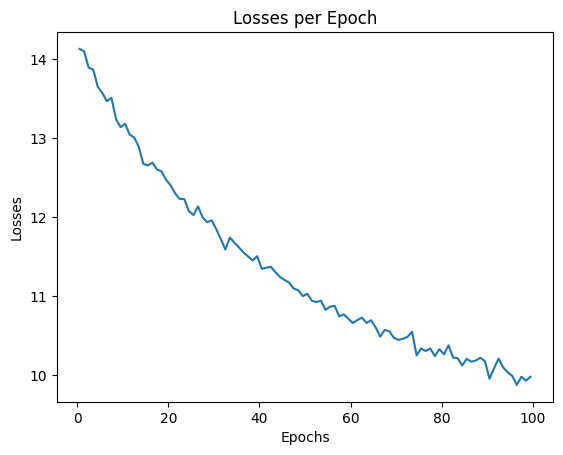

In [113]:
with open("runs/epochs.pkl", "rb") as f:
    epochs = np.array(pickle.load(f))

with open("runs/losses.pkl", "rb") as f:
    losses = np.array(pickle.load(f))
    
epochs_avg = epochs.reshape(n_epochs, -1).mean(axis=1)
losses_avg = losses.reshape(n_epochs, -1).mean(axis=1)
plt.plot(epochs_avg, losses_avg)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Losses per Epoch")

### **Testing Results**

After the model has gone through its training epochs, it's evaluation time. Since there are 10 classes, the result of each class prediction is stored as a list in order to compute each class's accuracy. The evaluation loop is the same as the training loop, but no gradients are computed since the model parameters aren't being updated.

In [122]:
correct_classes = list(0 for _ in range(10))
total_classes = list(0 for _ in range(10))

# It's important to set the model to eval mode to ignore the dropout layer
cnet.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        _, predicted = torch.max(cnet(images), 1)
        correct = predicted.eq(labels)

        for idx in range(len(labels)):
            label = labels[idx]
            correct_classes[label] += correct[label].item()
            total_classes[label] += 1

for idx in range(10):
    class_accuracy = round(correct_classes[idx] / total_classes[idx] * 100, 2)
    print(f"Testing accuracy of {classes[idx]}: {class_accuracy}% ({correct_classes[idx]}/{total_classes[idx]})")

overall_correct = np.sum(correct_classes)
overall_total = np.sum(total_classes)
print(f"\n Testing accuracy overall: {round(overall_correct / overall_total * 100, 2)} % ({overall_correct}/{overall_total})")


Testing accuracy of plane: 80.3% (803/1000)
Testing accuracy of car: 84.7% (847/1000)
Testing accuracy of bird: 83.4% (834/1000)
Testing accuracy of cat: 82.6% (826/1000)
Testing accuracy of deer: 84.0% (840/1000)
Testing accuracy of dog: 83.7% (837/1000)
Testing accuracy of frog: 80.9% (809/1000)
Testing accuracy of horse: 83.5% (835/1000)
Testing accuracy of ship: 83.4% (834/1000)
Testing accuracy of truck: 82.8% (828/1000)

 Testing accuracy overall: 82.93 % (8293/10000)


### **Testing Results Visualization**

It's important to visualize the results of the testing to identify any potential bugs/trends that could help in improving the model. This takes in a batch from the test set and then shows the model's prediction vs the actual image label. The imshow function is there to undo the transforms done to the testing dataset images (unnormalizing the image and converting it from Tensor image).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

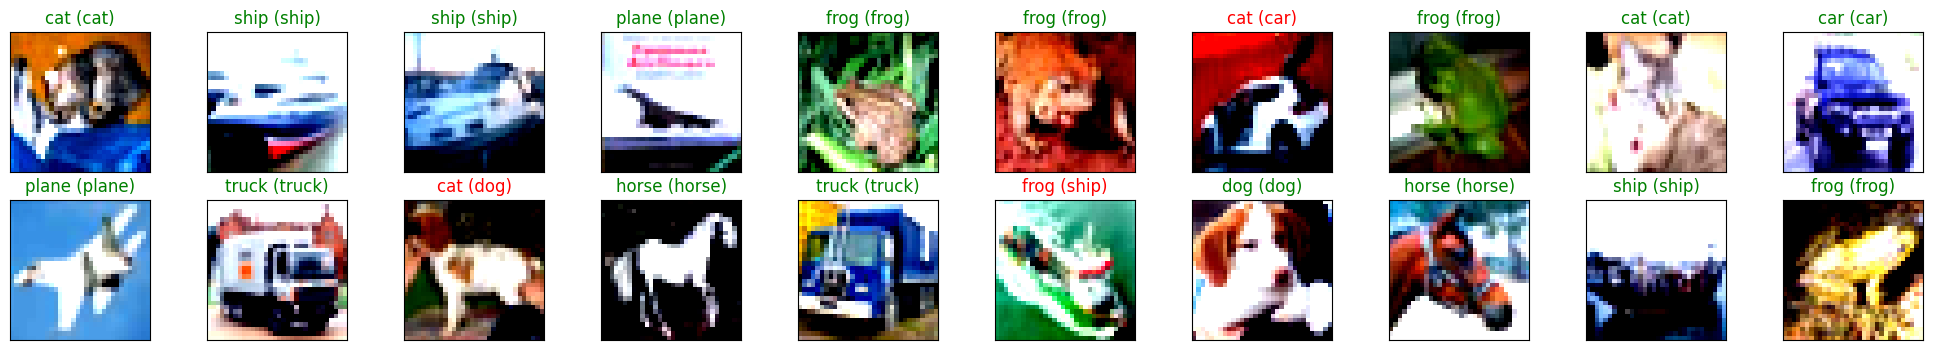

In [116]:
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1,2,0)))

data_iter = iter(test_loader)
images, labels = next(data_iter)
images = images.to(device)

_, predictions = torch.max(cnet(images), 1)

images = images.cpu().numpy() if device == torch.device("cuda") else images.numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    color = "green" if predictions[idx] == labels[idx].item() else "red"
    ax.set_title(f"{classes[predictions[idx]]} ({(classes[labels[idx]])})", color=color)